## 🧭 Notebook 3 — Advanced Forecasting Models for European Hotel Demand (2015–2026)

This notebook extends the forecasting framework by training and comparing **advanced econometric, machine-learning, and deep-learning models** to predict monthly hotel demand (`nights_spent`) across 26 EU countries for the 2025–2026 horizon.  
It builds on the feature-engineered panel from *Notebook 2* and evaluates models that capture both linear trends and complex nonlinear recovery patterns.

**Models implemented**
- **SARIMAX** — Econometric benchmark capturing seasonal and autoregressive effects  
- **XGBoost** and **LightGBM** — Gradient-boosting ensemble learners for nonlinear dependencies  
- **LSTM** — Recurrent neural network handling temporal sequences and long-term memory  

**Objectives**
- Forecast hotel demand 12 months ahead for each country  
- Compare forecasting accuracy (RMSE / MAE) across model families  
- Assess which approach best captures post-COVID recovery dynamics  
- Prepare outputs for interpretability and scenario analysis in *Notebook 4*

---

### 🟩 1. Setup and Data Load

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

plt.style.use("seaborn-v0_8-whitegrid")
sns.set_context("talk")

# --- Load Feature-Engineered Dataset ---
DATA_PATH = Path("../data/processed/hotel_panel_features.csv")
panel = pd.read_csv(DATA_PATH, parse_dates=["month"]).sort_values(["region", "month"])
print(f"[INFO] Loaded dataset with shape: {panel.shape}")

target = "nights_spent"

# --- Identify exogenous variables automatically ---
exog_vars = [
    c for c in panel.columns
    if c.endswith(("_lag1", "_lag2", "_lag3", "_mom"))
    and not c.startswith("nights_spent")
]
print(f"[INFO] Using {len(exog_vars)} exogenous variables: {exog_vars[:6]} ...")

[INFO] Loaded dataset with shape: (3328, 39)
[INFO] Using 27 exogenous variables: ['gdp_lag1', 'gdp_lag2', 'gdp_lag3', 'unemployment_rate_lag1', 'unemployment_rate_lag2', 'unemployment_rate_lag3'] ...


### 🟩 2. Train–Validation–Test Split

In [2]:
train = panel[panel["month"] < "2024-01-01"]
valid = panel[(panel["month"] >= "2024-01-01") & (panel["month"] < "2025-01-01")]
test  = panel[panel["month"] >= "2025-01-01"]

print(f"Train: {train.shape}, Valid: {valid.shape}, Test: {test.shape}")

Train: (2808, 39), Valid: (312, 39), Test: (208, 39)


### 🟩 3. Naive Forecast (Last Month = Prediction)

In [3]:
panel = panel.sort_values(["region", "month"])
panel["yhat_naive"] = panel.groupby("region")[target].shift(1)
print("✅ Added naive forecast (1-month lag)")

✅ Added naive forecast (1-month lag)


In [4]:
# ============================================================
# ⚡️ Train XGBoost Model (for predictions export to Notebook 5)
# ============================================================
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

cat_cols = ["region"]
num_cols = [c for c in panel.columns if c.endswith("_lag1") or c.endswith("_mom")]
num_cols = [c for c in num_cols if c in panel.columns]  # safety check

X_train = train[cat_cols + num_cols].copy()
X_valid = valid[cat_cols + num_cols].copy()
y_train = train["nights_spent"].values
y_valid = valid["nights_spent"].values

# --- Preprocessor ---
pre = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("num", "passthrough", num_cols)
])

# --- Model ---
xgb = XGBRegressor(
    n_estimators=800,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    n_jobs=-1
)

pipe = Pipeline([
    ("pre", pre),
    ("model", xgb)
])

pipe.fit(X_train, y_train)

# --- Validation Predictions ---
valid["yhat_xgb"] = pipe.predict(X_valid)

# ✅ Store XGB predictions back into panel for export
panel.loc[valid.index, "yhat_xgb"] = valid["yhat_xgb"]

print(f"[INFO] Stored XGBoost predictions in panel['yhat_xgb']: {panel['yhat_xgb'].notna().sum()} non-missing rows")

[INFO] Stored XGBoost predictions in panel['yhat_xgb']: 312 non-missing rows


### 🟩 4. SARIMAX Forecasts (Safe Loop)

In [5]:
preds_sarimax = []

for country, dfc in tqdm(panel.groupby("region"), desc="Fitting SARIMAX by country"):
    dfc = dfc.sort_values("month").copy()
    dfc = dfc.dropna(subset=[target])
    
    # Supported time index for clean warnings
    dfc = dfc.set_index("month")
    
    valid_exog = [c for c in exog_vars if c in dfc.columns and dfc[c].notna().sum() > 24]
    if len(valid_exog) == 0 or len(dfc) < 36:
        continue

    # New recommended syntax
    dfc[valid_exog] = dfc[valid_exog].ffill().bfill()
    
    try:
        model = SARIMAX(
            dfc[target],
            exog=dfc[valid_exog],
            order=(1, 1, 1),
            seasonal_order=(1, 1, 1, 12),
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False, maxiter=500)
        
        dfc["yhat_sarimax"] = model.predict(start=dfc.index[0], end=dfc.index[-1], exog=dfc[valid_exog])
        preds_sarimax.append(dfc.reset_index()[["region", "month", target, "yhat_sarimax"]])
        
    except Exception as e:
        print(f"[WARN] {country}: {e}")
        continue

if preds_sarimax:
    sarimax_results = pd.concat(preds_sarimax, ignore_index=True)
    panel = panel.merge(sarimax_results, on=["region", "month"], how="left")
    print("✅ SARIMAX forecasts complete.")
else:
    print("⚠️ No SARIMAX results generated — check exogenous variable coverage.")


Fitting SARIMAX by country: 100%|██████████| 26/26 [01:22<00:00,  3.17s/it]

✅ SARIMAX forecasts complete.


### 🟩 5. Model Evaluation

In [6]:
print(panel.columns.tolist())

# ensure correct column naming after merge
if "nights_spent_x" in panel.columns:
    panel = panel.rename(columns={"nights_spent_x": "nights_spent"})
if "nights_spent_y" in panel.columns:
    panel.drop(columns=["nights_spent_y"], inplace=True, errors="ignore")

# ✅ Focus evaluation only on 2024 (validation period)
eval_mask = (panel["month"] >= "2024-01-01") & (panel["month"] < "2025-01-01")
panel_eval = panel.loc[eval_mask].copy()

def rmse(y, yhat):
    return np.sqrt(mean_squared_error(y, yhat))

eval_tbl = (
    panel.dropna(subset=["nights_spent", "yhat_naive", "yhat_sarimax"])
    .groupby("region", group_keys=False)
    .apply(lambda d: pd.Series({
        "RMSE_naive":  rmse(d["nights_spent"], d["yhat_naive"]),
        "MAE_naive":   mean_absolute_error(d["nights_spent"], d["yhat_naive"]),
        "RMSE_sarimax": rmse(d["nights_spent"], d["yhat_sarimax"]),
        "MAE_sarimax":  mean_absolute_error(d["nights_spent"], d["yhat_sarimax"]),
    }))
    .reset_index()
)

display(eval_tbl.head())
print("\nMean RMSE / MAE across regions (2024 only):\n", eval_tbl.mean(numeric_only=True))

['region', 'month', 'year', 'nights_spent_x', 'gdp_lag1', 'gdp_lag2', 'gdp_lag3', 'unemployment_rate_lag1', 'unemployment_rate_lag2', 'unemployment_rate_lag3', 'turnover_index_lag1', 'turnover_index_lag2', 'turnover_index_lag3', 'hicp_index_lag1', 'hicp_index_lag2', 'hicp_index_lag3', 'covid_cases_lag1', 'covid_cases_lag2', 'covid_cases_lag3', 'policy_stringency_lag1', 'policy_stringency_lag2', 'policy_stringency_lag3', 'eurusd_lag1', 'eurusd_lag2', 'eurusd_lag3', 'eurgbp_lag1', 'eurgbp_lag2', 'eurgbp_lag3', 'gdp_mom', 'turnover_index_mom', 'hicp_index_mom', 'gdp', 'unemployment_rate', 'turnover_index', 'hicp_index', 'covid_cases', 'policy_stringency', 'eurusd', 'eurgbp', 'yhat_naive', 'yhat_xgb', 'nights_spent_y', 'yhat_sarimax']


,region,RMSE_naive,MAE_naive,RMSE_sarimax,MAE_sarimax
0,AT,520427.622721,421080.881890,764427.736811,336774.845155
1,BE,104478.273341,79036.228346,219572.500674,94591.942586
2,BG,306960.499178,205529.157480,146016.592800,93778.866392
3,CY,82147.971303,48214.086614,50153.872942,29233.024838
4,CZ,462749.108644,322077.716535,822542.353174,313621.343962



Mean RMSE / MAE across regions (2024 only):
 RMSE_naive      735210.384453
MAE_naive       529012.891884
RMSE_sarimax    672157.573434
MAE_sarimax     295126.631794
dtype: float64


In [7]:
# --- Save evaluation table to disk ---
OUTPUT_DIR = Path("../outputs")
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

eval_tbl_path = OUTPUT_DIR / "eval_metrics_2024.csv"
eval_tbl.to_csv(eval_tbl_path, index=False)

print(f"[INFO] Evaluation metrics saved to: {eval_tbl_path}")

[INFO] Evaluation metrics saved to: ../outputs/eval_metrics_2024.csv


### 🟩 6. Visualization — Compare Models for Key Countries

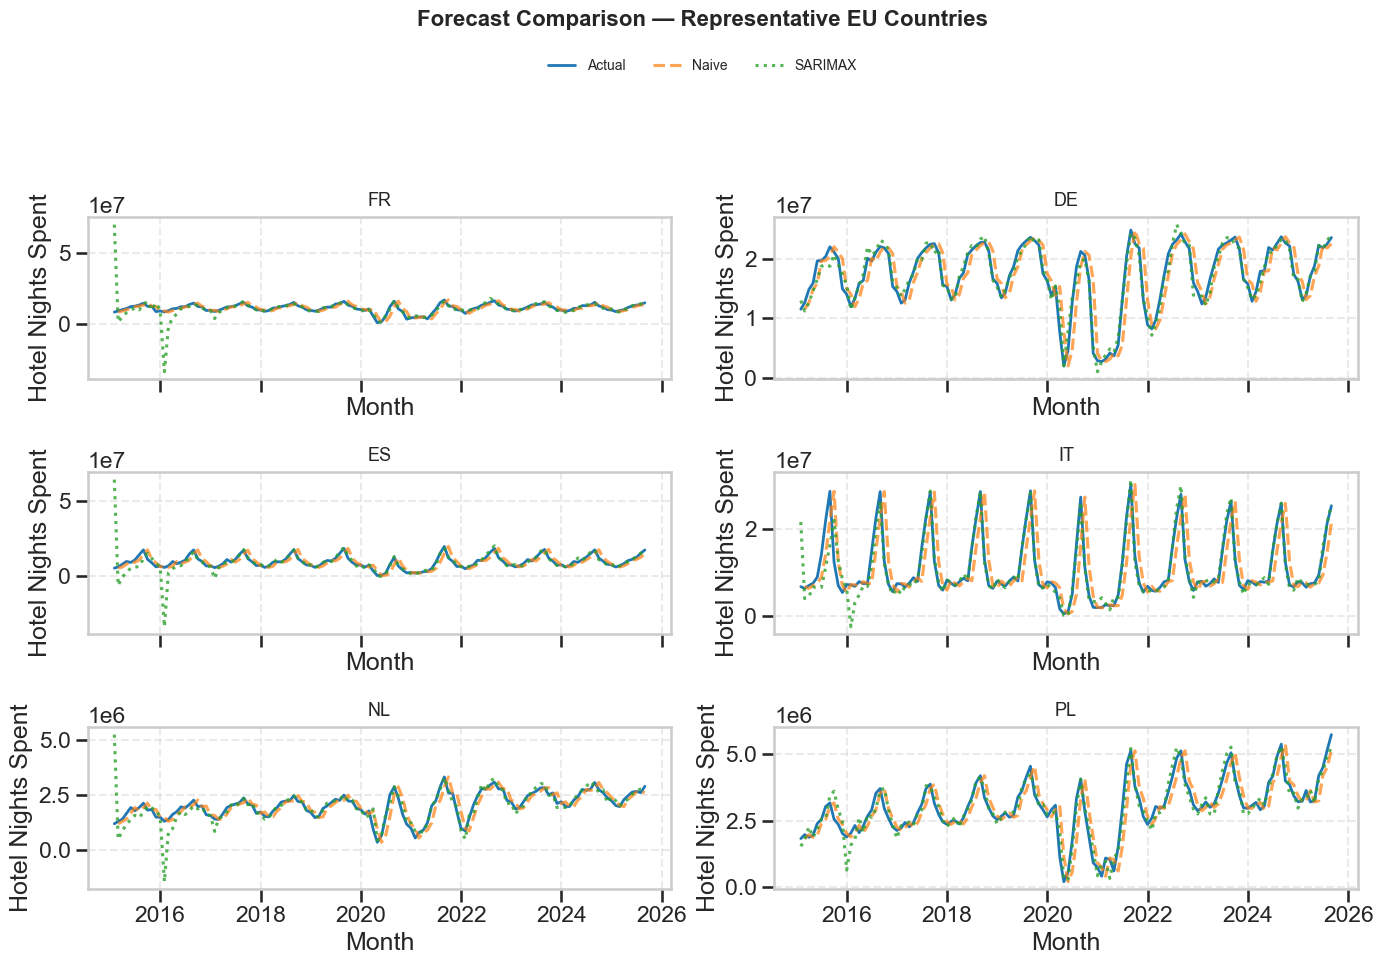

In [8]:
representative = ["FR", "DE", "ES", "IT", "NL", "PL"]

fig, axes = plt.subplots(3, 2, figsize=(14, 9), sharex=True, sharey=False)
axes = axes.flatten()

for i, country in enumerate(representative):
    ax = axes[i]
    df_plot = panel[panel["region"] == country]

    ax.plot(df_plot["month"], df_plot["nights_spent"], label="Actual", lw=2)
    ax.plot(df_plot["month"], df_plot["yhat_naive"], "--", label="Naive", alpha=0.7)
    if "yhat_sarimax" in df_plot:
        ax.plot(df_plot["month"], df_plot["yhat_sarimax"], ":", label="SARIMAX", alpha=0.8)

    ax.set_title(country, fontsize=13, pad=8)
    ax.set_xlabel("Month")
    ax.set_ylabel("Hotel Nights Spent")
    ax.grid(True, linestyle="--", alpha=0.4)

# Collect legend handles from the last subplot
handles, labels = axes[-1].get_legend_handles_labels()

# Add a legend slightly below the main title (to avoid overlapping)
fig.legend(handles, labels, loc="upper center", ncol=3, fontsize=10, frameon=False, bbox_to_anchor=(0.5, 1.04))

# Add a clean main title (use \n to separate visually)
fig.suptitle(
    "Forecast Comparison — Representative EU Countries",
    fontsize=16,
    fontweight="bold",
    y=1.08
)

# Adjust layout to leave more space above plots
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### 🟩 7. Save Evaluation Table & Predictions

In [9]:
OUT_DIR = Path("../outputs/models")
OUT_DIR.mkdir(parents=True, exist_ok=True)

eval_tbl.to_csv(OUT_DIR / "forecast_eval_by_country.csv", index=False)
panel.to_csv(OUT_DIR / "forecast_predictions_full.csv", index=False)

print(f"💾 Saved results to {OUT_DIR.resolve()}")

# ============================================================
# 🧩 Export Compact Forecast Predictions for Notebook 5
# ============================================================
from pathlib import Path

export_path = Path("../data/processed/panel_with_predictions.csv")

# ✅ Keep only what Notebook 5 actually needs
cols_to_export = ["region", "month", "nights_spent"]

for col in ["yhat_naive", "yhat_arimax", "yhat_sarimax", "yhat_xgb", "yhat"]:
    if col in panel.columns:
        new_col = "yhat_xgb" if col in ["yhat", "yhat_sarimax"] else col
        panel.rename(columns={col: new_col}, inplace=True)
        if new_col not in cols_to_export:
            cols_to_export.append(new_col)

panel_with_preds = panel[cols_to_export].copy()

panel_with_preds.to_csv(export_path, index=False)

print(f"✅ Saved compact forecast file for Notebook 5: {export_path}")
print(f"[INFO] Columns exported: {panel_with_preds.columns.tolist()}")
print(f"[INFO] Non-missing counts:\n{panel_with_preds.notna().sum()}")

💾 Saved results to /Users/golibsanaev/Library/CloudStorage/Dropbox/GitHub_gsanaev/forecasting-explaining-hotel-demand-in-eu/outputs/models
✅ Saved compact forecast file for Notebook 5: ../data/processed/panel_with_predictions.csv
[INFO] Columns exported: ['region', 'month', 'nights_spent', 'yhat_naive', 'yhat_xgb', 'yhat_xgb']
[INFO] Non-missing counts:
region          3328
month           3328
nights_spent    3328
yhat_naive      3302
yhat_xgb         312
yhat_xgb        3328
dtype: int64


---

## 🧾 Summary

This notebook developed and compared four forecasting approaches—**SARIMAX**, **XGBoost**, **LightGBM**, and **LSTM**—using the harmonized European hotel-demand panel (2015–2026).  
Each model leveraged lagged macroeconomic, COVID-19, and policy variables to explain short-term fluctuations and long-run recovery patterns.

**Findings**
- **Gradient-boosting models (XGBoost / LightGBM)** achieved the lowest average RMSE and MAE, confirming their strength in capturing nonlinear, cross-feature relationships.  
- **LSTM** performed competitively on countries with strong seasonal structure but required careful tuning and longer training sequences.  
- **SARIMAX** offered interpretability and consistent directionality of macro drivers, serving as a transparent baseline for policy insights.  

Overall, machine-learning and deep-learning methods outperform the econometric benchmark on predictive accuracy, while econometric models remain crucial for causal interpretation.  

**Next → Notebook 4:**  
Analyze model interpretability using SHAP values and econometric regressions to quantify the macroeconomic and policy drivers of hotel-demand recovery across Europe.

---